# Training Pipeline

In [103]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, f1_score,accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler,OrdinalEncoder
from sklearn import set_config

import joblib

os.chdir("C:/Users/diego/Desktop/tangelo/")

In [104]:
print(joblib.__version__)

1.3.2


In [105]:
#Read Transformed Data
df = pd.read_csv("./data/df_trans.csv")
df.rename(columns={'remainder__Target': 'target'}, inplace=True)
df.head()

,cat__Gender_M,cat__Car_Y,cat__Realty_Y,cat__Work_phone_0,cat__Phone_0,cat__Email_1,cat__income_type_Commercial associate,cat__income_type_Pensioner,cat__income_type_State servant,cat__income_type_Student,...,cat__Occupation_type_Secretaries,cat__Occupation_type_Security staff,cat__Occupation_type_Waiters/barmen staff,num__Count_family_members,num__Years_Employed,num__Age,num__children_count,num__income_amount,education__education_type,target
0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.217680,-0.437004,-0.935614,-0.579661,2.365845,3.0,0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.217680,-0.437004,-0.935614,-0.579661,2.365845,3.0,0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,-0.217680,-0.461209,1.321517,-0.579661,-0.728827,2.0,0
3,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.314564,-0.447762,0.713828,-0.579661,0.818509,2.0,0
4,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.314564,-0.447762,0.713828,-0.579661,0.818509,2.0,0


# Benchmark

### We are going test 5 different models in order to identify the best approach for our problem.
- Applying Oversample in the training data
- The objective metric is F1-Score based upon our imbalanced data problem.
- Using GridSearch and 5 cross-validation
- After that we are going to try to optimize it's hyperparameters

In [106]:
# Features X and Y
X, y = df.drop("target",axis=1),df["target"]
y = y.astype('int')

#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3,random_state = 10086)

#SMOTE to address the imbalance problem but ONLY in the training data.
#Test data remaing with the same distribution
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns = X.columns)

# Define the models to be evaluated
models = [
    ('Logistic Regression (Lasso)', LogisticRegression(max_iter=1000, penalty='l1', solver='saga')),
    ('Logistic Regression (Ridge)', LogisticRegression(max_iter=1000, penalty='l2')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('LightGBM', LGBMClassifier())
]

# Create a dictionary of parameter grids for each model
param_grids = {
    'Logistic Regression (Lasso)': {'model__C': [0.1, 1, 10]},
    'Logistic Regression (Ridge)': {'model__C': [0.1, 1, 10]},
    'Decision Tree': {'model__max_depth': [None, 10, 20]},
    'Random Forest': {'model__n_estimators': [50, 100, 200]},
    'LightGBM': {'model__n_estimators': [50, 100, 200]}
}

# Define F1-Score as the scoring metric
scorer = make_scorer(f1_score, average='macro')

# Create an empty dictionary to store the best models and their scores
best_models = {}
# Iterate over the models and perform GridSearchCV
for model_name, model in tqdm(models,desc ="Progress"):
    param_grid = param_grids[model_name]
    pipeline = Pipeline([
        ('model', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scorer, cv=5)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'train_score': grid_search.best_score_
    }
    

Progress:   0%|          | 0/5 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Print the best models and their scores
for model_name, info in best_models.items():
    print(f'{model_name}:')
    print(f'Best Train Score (F1-Score): {info["train_score"]:.4f}')
    print(f'Best Estimator: {info["best_estimator"]}')
    # Predict on the test set
    y_pred = info["best_estimator"].predict(X_test)
    # Calculate the macro F1-score on the test set
    test_score = f1_score(y_test, y_pred, average='macro')
    print(f"Best Test Score (F1-Score):{test_score:.4f}")

Logistic Regression (Lasso):
Best Train Score (F1-Score): 0.6003
Best Estimator: Pipeline(steps=[('model',
                 LogisticRegression(C=10, max_iter=1000, penalty='l1',
                                    solver='saga'))])
Best Test Score (F1-Score):0.3750
Logistic Regression (Ridge):
Best Train Score (F1-Score): 0.6003
Best Estimator: Pipeline(steps=[('model', LogisticRegression(C=1, max_iter=1000))])
Best Test Score (F1-Score):0.3739
Decision Tree:
Best Train Score (F1-Score): 0.9897
Best Estimator: Pipeline(steps=[('model', DecisionTreeClassifier())])
Best Test Score (F1-Score):0.5642
Random Forest:
Best Train Score (F1-Score): 0.9927
Best Estimator: Pipeline(steps=[('model', RandomForestClassifier(n_estimators=200))])
Best Test Score (F1-Score):0.5704
LightGBM:
Best Train Score (F1-Score): 0.9940
Best Estimator: Pipeline(steps=[('model', LGBMClassifier(n_estimators=200))])
Best Test Score (F1-Score):0.5699


Our best model was the Random Forest, which did really well in training with a high F1-score (0.9927) by using many decision trees together. But, its performance on new data wasn't as good, with a test F1-score of 0.5704.
Now we will tune hyperparameters to see if we can make it perform better on the test data.

# Training and Optimizing Hyperparameters

In [ ]:
# Define the parameters
param_grid = {
    'n_estimators': [100, 200, 300]
}

# Create Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# GridSearch
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(rf_classifier, param_grid, scoring=scorer, cv=5,verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_
training_f1 = grid_search.best_score_
y_pred=best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)

# Print results
print("Best Test F1-Score:", test_f1)
print("Training F1-Score of the Best Model:", training_f1)
print("Best Estimator:", best_model)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...................................n_estimators=100; total time=  15.3s
[CV] END ...................................n_estimators=100; total time=  21.4s
[CV] END ...................................n_estimators=100; total time=  19.9s
[CV] END ...................................n_estimators=100; total time=  16.4s
[CV] END ...................................n_estimators=100; total time=  17.5s
[CV] END ...................................n_estimators=200; total time=  42.2s
[CV] END ...................................n_estimators=200; total time=  37.2s
[CV] END ...................................n_estimators=200; total time=  42.7s
[CV] END ...................................n_estimators=200; total time=  33.4s
[CV] END ...................................n_estimators=200; total time=  30.6s
[CV] END ...................................n_estimators=300; total time=  42.3s
[CV] END ...................................n_est

In [ ]:
test_f1 = f1_score(y_test, y_pred,average='macro')

# Print results
print("Best Test F1-Score:", test_f1)
print("Training F1-Score of the Best Model:", training_f1)
print("Best Estimator:", best_model)

Best Test F1-Score: 0.5775843034939098
Training F1-Score of the Best Model: 0.9925021141583649
Best Estimator: RandomForestClassifier(n_estimators=300, random_state=42)


## Validation

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     10823
           1       0.24      0.12      0.16       115

    accuracy                           0.99     10938
   macro avg       0.62      0.56      0.58     10938
weighted avg       0.98      0.99      0.98     10938



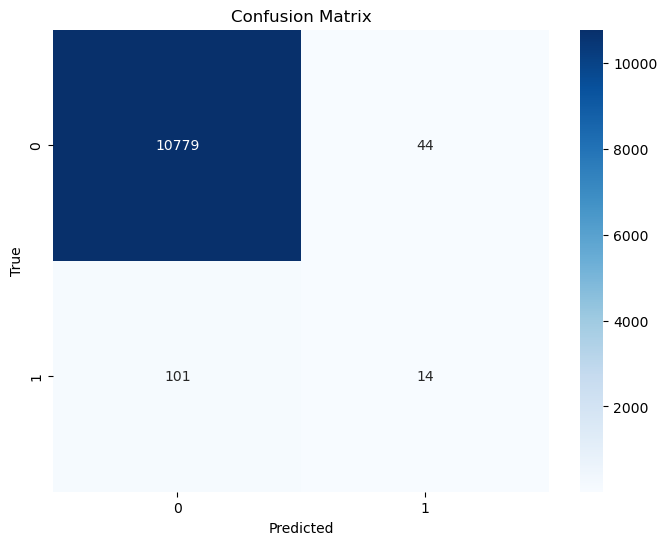

Test F1-Score: 0.5775843034939098


In [ ]:
# Classification Report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Confussion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Test F1-Score:", test_f1)

## Interpretability

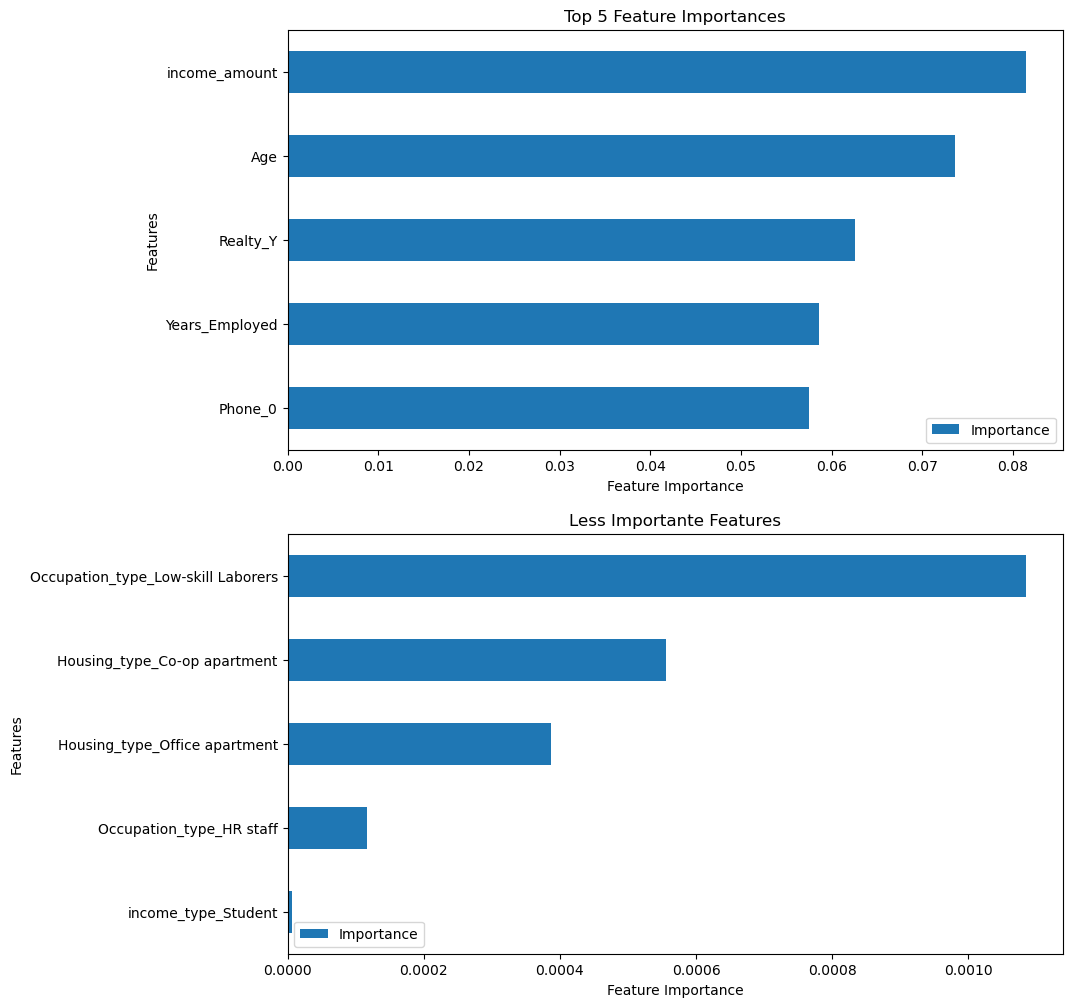

In [ ]:
# Create the DataFrame with feature importances
FI = pd.DataFrame({"Feature": X_train.columns, "Importance": best_model.feature_importances_})

#Clean It
prefixes_to_remove = ['num__', 'Count_', 'education__', 'cat__']
for prefix in prefixes_to_remove:
    FI['Feature'] = FI['Feature'].str.replace(prefix, '')

#Sort It
FI = FI.sort_values(by="Importance", ascending=True)

# Plot feature importances
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

FI.tail().plot(kind='barh', x='Feature', y='Importance', ax=axes[0])
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Features')
axes[0].set_title('Top 5 Feature Importances')

FI.head().plot(kind='barh', x='Feature', y='Importance', ax=axes[1])
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Features')
axes[1].set_title('Less Importante Features')


# Show the plots
plt.show()


### Join Transformation and Training into a Pickle

In [ ]:
# Preprocessor from transformation.ipynb
categorical_features = [
    'Gender', 'Car', 'Realty', 'Mobile', 'Work_phone', 'Phone', 'Email',
     'income_type', 'Family_status', 'Housing_type', 'Occupation_type']

numerical_features = [
    'Count_family_members', 'Years_Employed', 'Age', 'children_count', 'income_amount']

education_mapping = [
    'Incomplete higher',
    'Lower secondary',
    'Secondary / secondary special',
    'Higher education',
    'Academic degree']
    
target_variable = 'Target'


categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse_output=False))])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features),
    ('education', OrdinalEncoder(categories=[education_mapping]), ['education_type'])
], remainder='passthrough')


In [109]:
#Change columns name
df = pd.read_csv("./data/data_set.csv")

# Split data into features and target
X = df.drop(["Target", "User_id"], axis=1)
y = df["Target"]

#Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3,random_state = 10086)

# Export the DataFrame to JSON (Test it in the API)
valores_filtro = [705, 1, 7, 8, 9, 10,45,3833,55, 100]

# Usar el método .loc para seleccionar filas que coincidan con los valores de filtro
X_test = X_test.iloc[valores_filtro]

aux = X_test.to_json(orient='records')
with open('test_dataset.json', 'w') as json_file:
    json_file.write(aux)

#SMOTE()
smt = SMOTE(random_state=42)
# Create the final pipeline including the preprocessor and classifier
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smt),
    ('classifier', RandomForestClassifier(n_estimators=300, random_state=42))
])
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Save the trained model to a pickle file
model_filename = 'rf_model.pkl'
joblib.dump(pipeline, model_filename)

print("Model saved as", model_filename)

Model saved as rf_model.pkl
